In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from sklearn import preprocessing
from keras.utils import to_categorical
import keras
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras_preprocessing.image import ImageDataGenerator
from tabulate import tabulate
import seaborn as sn

## Creating data generator

In [2]:
'''
Creating data generator
'''
datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
'''
Running generator for train, validation and test sets
'''

train_generator = train_datagen.flow_from_directory(
        'face-dataset/Face Mask Dataset/Train',
        color_mode="grayscale",
        target_size=(128, 128), #change target size here and in model to check different image sizes
        batch_size=32,
        shuffle=True,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'face-dataset/Face Mask Dataset/Validation',
        color_mode="grayscale",
        target_size=(128, 128), #change target size here and in model to check different image sizes
        batch_size=32,
        shuffle = True,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        'face-dataset/Face Mask Dataset/Test',
        color_mode="grayscale",
        target_size=(128, 128), #change target size here and in model to check different image sizes
        batch_size=32,
        shuffle = True,
        class_mode='binary')


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Creating the model

In [4]:
'''
Model Definition for Light Weight CNN 
'''

model=Sequential()
model.add(Conv2D(16,(3,3),input_shape=(128,128,1),activation='relu',strides=2))
model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy']) 

In [6]:
# '''
# Fitting the model
# '''
# history = model.fit(
#         train_generator,
#         epochs=15,
#         validation_data=validation_generator
#         )

In [7]:
# '''
# Graphs for training matrics
# '''
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [8]:
model = keras.models.load_model('saved_model')

In [9]:
'''
Evaluating the model on test generator
'''
model.evaluate(test_generator,return_dict=True)

31/31 [==============================] - 4s 120ms/step - loss: 0.0290 - accuracy: 0.9889


{'loss': 0.02897755615413189, 'accuracy': 0.9889112710952759}

## OpenCV model 

In [10]:
'''
Importing SSDnet which uses res10 architecture for face detection
'''

detector = cv2.dnn.readNetFromCaffe("face-detec/deploy.prototxt","face-detec/res10_300x300_ssd_iter_140000.caffemodel")


In [11]:

def use_SSD_face_detector(path):
    '''
    Function to read an image and detect faces in it using SSDNET
    Parameters: 
    path : is the path to the image
    '''
    img = cv2.imread(path)
    img = cv2.resize(img,(300,300))
    img_blob = cv2.dnn.blobFromImage(img)
    detector.setInput(img_blob)
    detections = detector.forward()
    detections = detections[0][0]
    faces=[]
    for i in range(len(detections)):
        if detections[i][2]>0.8:
            faces.append(detections[i])
    if len(faces) == 0:
        return -1
    else:
        return 1
    for face in faces:
        left = int(face[3] * 300)
        top = int(face[4] * 300)
        right = int(face[5] * 300 )
        bottom = int(face[6]* 300)
        detected_faces = img[top:bottom,left:right]
        plt.imshow(detected_faces[:,:,::-1])
        plt.show()


In [12]:
'''
Testing SSDNET on the *************
'''

with_mask_face = []
without_mask_face = []
dirname = 'totest2/dataset/with_mask/'
for filename in os.listdir(dirname):
    path = dirname + filename
    try:    
        with_mask_face.append(use_SSD_face_detector(path))
    except Exception as e:
        print(e)
x=with_mask_face.count(1)
z=with_mask_face.count(-1)
dirname = 'totest2/dataset/without_mask/'
for filename in os.listdir(dirname):
    path = dirname + filename
    try:    
        without_mask_face.append(use_SSD_face_detector(path))
    except Exception as e:
        print(e)
y=without_mask_face.count(1)
a=without_mask_face.count(-1)

In [13]:
print(tabulate([['With mask and face detected', x], ['With mask and face not detected', z],['Without mask and not detected',a],['Without mask and face detected', y]], headers=['Category ', 'No. of Images'], tablefmt='orgtbl'))

| Category                        |   No. of Images |
|---------------------------------+-----------------|
| With mask and face detected     |             204 |
| With mask and face not detected |              16 |
| Without mask and not detected   |               2 |
| Without mask and face detected  |             218 |


## Final testing


In [14]:
def detect_mask_for_img(img):
    '''
    Function for detecting mask in image
    Uses trained CNN to detect mask
    Parameter:
    
    img - 128X128 image of the face
    
    Returns:
    1 if No mask is detected
    0 if mask is detected
    '''
    img = img/255
    new_img=cv2.resize(img,(128,128))
    new_img=new_img.reshape(-1,128,128,1)
    
    predict=model.predict(new_img)
    if(predict>0.5):
        print("No mask")
        return 1
    else:
        print("Mask")
        return 0

In [15]:
confusion_matrix=[[0,0],[0,0]]

In [16]:
def final_model_mask(path):
    '''
    Function to use SSDnet and custom CNN to detect face mask
    
    Parameters:
    path - absolute filename
    
    
    '''
    img = cv2.imread(path)
    img = cv2.resize(img,(300,300))
    img_blob = cv2.dnn.blobFromImage(img)
    detector.setInput(img_blob)
    detections = detector.forward()
    detections = detections[0][0]
    faces=[]
    for i in range(len(detections)):
        if detections[i][2]>0.8:
            faces.append(detections[i])
    print(faces)
    img = cv2.imread(path,0)
    img = cv2.resize(img,(300,300))
    if len(faces) == 0:
        temp=detect_mask_for_img(path)
    else:
        for face in faces:
            left = int(face[3] * 300)
            top = int(face[4] * 300)
            right = int(face[5] * 300 )
            bottom = int(face[6]* 300)
            detected_faces = img[top:bottom,left:right]
            temp = detect_mask_for_img(detected_faces)
    if temp == 0:
        confusion_matrix[0][0]+=1
    elif temp == 1:
        confusion_matrix[0][1]+=1


In [17]:
def final_model_nomask(path):
    '''
    Function to use SSDnet and custom CNN to detect face mask
    
    Parameters:
    path - absolute filename
    
    
    '''
    img = cv2.imread(path)
    img = cv2.resize(img,(300,300))
    img_blob = cv2.dnn.blobFromImage(img)
    detector.setInput(img_blob)
    detections = detector.forward()
    detections = detections[0][0]
    faces=[]
    for i in range(len(detections)):
        if detections[i][2]>0.8:
            faces.append(detections[i])
    print(faces)
    img = cv2.imread(path,0)
    img = cv2.resize(img,(300,300))
    if len(faces) == 0:
        temp=detect_mask_for_img(path)
    else:
        for face in faces:
            left = int(face[3] * 300)
            top = int(face[4] * 300)
            right = int(face[5] * 300 )
            bottom = int(face[6]* 300)
            detected_faces = img[top:bottom,left:right]
            temp = detect_mask_for_img(detected_faces)
    if temp == 0:
        confusion_matrix[1][0]+=1
    elif temp == 1:
        confusion_matrix[1][1]+=1

In [18]:
'''
Evaluating model with the test set
'''

dirname = 'totest2/dataset/with_mask/'
for filename in os.listdir(dirname):
    path = dirname + filename
    try:
        final_model_mask(path)
    except:
        continue

dirname = 'totest2/dataset/without_mask/'
for filename in os.listdir(dirname):
    path = dirname + filename
    try:
        final_model_nomask(path)
    except:
        continue

[array([0.        , 1.        , 0.9898    , 0.3522559 , 0.16745126,
       0.6581707 , 0.44812894], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9587508 , 0.18381749, 0.1734252 ,
       0.5798733 , 0.76704854], dtype=float32)]
Mask
[array([0.        , 1.        , 0.99824774, 0.3486989 , 0.07236575,
       0.6215995 , 0.42792594], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9981336 , 0.35029608, 0.16644558,
       0.5832109 , 0.67426765], dtype=float32)]
Mask
[]
[array([0.        , 1.        , 0.9745884 , 0.20120691, 0.15563121,
       0.5305171 , 0.73198795], dtype=float32)]
Mask
[array([0.0000000e+00, 1.0000000e+00, 9.9007821e-01, 1.8422154e-01,
       2.3841858e-05, 6.9634795e-01, 8.8238972e-01], dtype=float32)]
Mask
[array([0.        , 1.        , 0.973695  , 0.40953425, 0.2286404 ,
       0.7831539 , 0.5818821 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9864926 , 0.32773232, 0.22790477,
       0.7325386 , 0.8087541 ], dtype=float32)]
Mask
[arra

       0.5666327 , 0.7553878 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.998173  , 0.27316433, 0.24602173,
       0.59024566, 0.57209474], dtype=float32)]
Mask
[array([0.        , 1.        , 0.92129964, 0.35518175, 0.4708932 ,
       0.7241102 , 0.7818623 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9639244 , 0.38813978, 0.08118182,
       0.79965085, 0.8517584 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9883157 , 0.33023828, 0.26557526,
       0.75289565, 0.7566581 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9826392 , 0.15381953, 0.00584859,
       0.79817045, 0.6937615 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9969181 , 0.36728317, 0.27646816,
       0.6308869 , 0.68905926], dtype=float32)]
Mask
[array([0.        , 1.        , 0.99204785, 0.4399207 , 0.19240911,
       0.5718038 , 0.4443733 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9966389 , 0.23261094, 0.18409544,
       0.5406794 , 0.80066663], 

Mask
[array([0.        , 1.        , 0.98155034, 0.45137516, 0.18351972,
       0.6732438 , 0.7917361 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.99646205, 0.3432896 , 0.12637351,
       0.7313945 , 0.4590435 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.99471587, 0.44995746, 0.16779195,
       0.7123114 , 0.5183302 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.94079363, 0.3789348 , 0.13508877,
       0.67228454, 0.4298096 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9483825 , 0.32231557, 0.13269144,
       0.6697922 , 0.8178658 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.994843  , 0.36652654, 0.15531561,
       0.69280976, 0.8992027 ], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9877599 , 0.52062154, 0.19882402,
       0.7759856 , 0.68167603], dtype=float32)]
Mask
[array([0.        , 1.        , 0.960338  , 0.34937352, 0.16044435,
       0.8490897 , 0.84928036], dtype=float32)]
Mask
[array([0.        , 1.     

[array([0.        , 1.        , 0.99702877, 0.3839461 , 0.104893  ,
       0.64369106, 0.47224608], dtype=float32)]
Mask
[array([0.        , 1.        , 0.9853607 , 0.53125346, 0.13998944,
       0.75418067, 0.66047156], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9999398 , 0.34959474, 0.0696789 ,
       0.764187  , 0.83243346], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99994886, 0.3237853 , 0.06286702,
       0.67566884, 0.9221567 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99995327, 0.22824186, 0.17185152,
       0.7862039 , 0.93007016], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9975177 , 0.20948666, 0.2741537 ,
       0.73947906, 0.9369805 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9999634 , 0.26517484, 0.15169325,
       0.7797502 , 0.9212526 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99977225, 0.12135503, 0.00251269,
       0.87025297, 0.98186827], dtype=float32)]
No mask
[array([0. 

No mask
[array([0.        , 1.        , 0.9994444 , 0.22943893, 0.23028117,
       0.7424911 , 0.94795114], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9999962 , 0.32479987, 0.14430253,
       0.6380038 , 0.6162899 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9976284 , 0.19453818, 0.268141  ,
       0.73505396, 0.9590559 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99995124, 0.21837503, 0.18155795,
       0.79198307, 0.9079866 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99991286, 0.0716207 , 0.        ,
       0.85220444, 0.9857347 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9995859 , 0.20031962, 0.08763456,
       0.85637915, 0.98313427], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99972445, 0.20641306, 0.12014124,
       0.7957505 , 0.95434475], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99870896, 0.21288356, 0.20101696,
       0.7309798 , 0.9415061 ], dtype=float32)]
Mask
[ar

No mask
[array([0.        , 1.        , 0.99999416, 0.3760831 , 0.06321584,
       0.60774577, 0.34169352], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99960417, 0.35939318, 0.01108658,
       0.68275374, 0.6664823 ], dtype=float32)]
No mask
[]
[array([0.        , 1.        , 0.9991059 , 0.3891785 , 0.11254206,
       0.6411717 , 0.7732866 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99996626, 0.19127166, 0.0800615 ,
       0.8314328 , 0.9191924 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9999161 , 0.37841728, 0.11831969,
       0.8276192 , 0.7199192 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99999917, 0.251941  , 0.1680984 ,
       0.6819037 , 0.5976901 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9999759 , 0.40260196, 0.2846915 ,
       0.82940865, 0.84774166], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9943065 , 0.3543101 , 0.01656672,
       0.8142825 , 0.8859745 ], dtype=float32)]
No ma

No mask
[array([0.        , 1.        , 0.9999201 , 0.18815261, 0.17757088,
       0.8544559 , 0.9505339 ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9997843 , 0.14739662, 0.0480226 ,
       0.8043391 , 0.98471785], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99987686, 0.23341528, 0.1813502 ,
       0.7471955 , 0.913543  ], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99987113, 0.24878275, 0.19178104,
       0.7489076 , 0.9532393 ], dtype=float32)]
No mask
[array([0.       , 1.       , 0.9995165, 0.2886266, 0.1819554, 0.7991505,
       0.9718639], dtype=float32)]
No mask
[array([0.        , 1.        , 0.99996614, 0.22154847, 0.1614947 ,
       0.8250339 , 0.95263815], dtype=float32)]
No mask
[array([0.        , 1.        , 0.9974003 , 0.22046953, 0.2299552 ,
       0.73338056, 0.98941267], dtype=float32)]
No mask
[array([0.        , 1.        , 0.999997  , 0.3540362 , 0.12379622,
       0.616751  , 0.698056  ], dtype=float32)]
No mask
[array(

<AxesSubplot:>

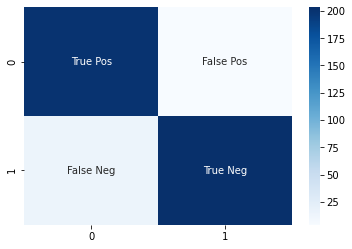

In [19]:
'''
Printing heatmap
'''
labels = ['True Pos','False Pos','False Neg','True Neg']
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

In [20]:
print(tabulate([['With mask and detected', confusion_matrix[0][0]], ['With mask but not detected', confusion_matrix[0][1]],['Without mask and not detected', confusion_matrix[1][1]],['Without mask and detected', confusion_matrix[1][0]]], headers=['Category ', 'No. of Images'], tablefmt='orgtbl'))

| Category                      |   No. of Images |
|-------------------------------+-----------------|
| With mask and detected        |             200 |
| With mask but not detected    |               4 |
| Without mask and not detected |             203 |
| Without mask and detected     |              15 |


## Metrics

In [21]:
precision = confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])
print("Precision : " + str(precision))

recall = confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])
print("Recall : "+ str(recall))

accuracy = (confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[1][0]+confusion_matrix[1][1])
print("Accuracy : " + str(accuracy))

f1 = 2 * ((precision*recall)/(precision+recall))
print("F1 score : " + str(f1))

Precision : 0.9803921568627451
Recall : 0.9302325581395349
Accuracy : 0.9549763033175356
F1 score : 0.9546539379474941


## MTCNN

In [22]:
from mtcnn import MTCNN
detector = MTCNN()

In [23]:
def detect_mask(path):
    print(path)
    img=cv2.imread(path)
    face=detector.detect_faces(img)
    test=[]
    if(len(face)==0):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = img/255
        new_img=cv2.resize(img,(128,128))
        new_img=new_img.reshape(-1,128,128,1)
        predict=model.predict(new_img)
        print(predict)
        return(0)
    for k in face:
        bounding_box=k['box']
        test.append([img,bounding_box])
    for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
            (bounding_box[0], bounding_box[1]),
            (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
            (0,155,255),
            10)
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = img/255
    img=img[bounding_box[1]:bounding_box[1]+bounding_box[3],bounding_box[0]:bounding_box[0]+bounding_box[2]]
    new_img=cv2.resize(img,(128,128))
    new_img=new_img.reshape(-1,128,128,1)
    

    predict=model.predict(new_img)
    if(predict>0.5):
        print("No mask")
    else:
        print("Mask")

In [24]:
from scipy.io import loadmat
annots = loadmat('MAFA-Label-Test/LabelTestAll.mat')
print(annots)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Sep 05 01:07:53 2017', '__version__': '1.0', '__globals__': [], 'LabelTest': array([[(array(['test_00000001.jpg'], dtype='<U17'), array([[2694, 1211,  353,  353,    1,    9,  105,  144,  337,    2,    3,
           2,    2,    1,   -1,   -1,   -1,   -1],
       [1754, 1449,   68,   68,    3,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1,   -1]], dtype=int16)),
        (array(['test_00000002.jpg'], dtype='<U17'), array([[113,  95, 226, 226,   1,   9,  71, 181, 221,   1,   3,   1,   2,
          3,  -1,  -1,  -1,  -1]], dtype=int16)),
        (array(['test_00000003.jpg'], dtype='<U17'), array([[352, 114, 151, 151,   1,  17,  45, 137, 135,   1,   3,   2,   2,
          3,  -1,  -1,  -1,  -1],
       [799, 217, 139, 139,   2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1]], dtype=int16)),
        ...,
        (array(['test_00004933.jpg'], dtype='<U17'), array(